**PROJEKT I PODSTAWY UCZENIA MASZYNOWEGO W TECHNOLOGIACH AKUSTYCZNYCH - BARTŁOMIEJ KRUCZEK, FILIP ULMANIEC**



# PRZYGOTOWANIA DANYCH

Instalacja potrzebnych bibliotek

In [ ]:
%pip install pydub
%pip install optuna
import librosa
import glob
from pydub import AudioSegment
from google.colab import drive
import os
from pydub import AudioSegment
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, accuracy_score, f1_score, make_scorer, confusion_matrix, log_loss, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.model_selection import cross_validate, StratifiedKFold
import pickle
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Łaczenie colaba z dyskiem googl'a, listowanie plików znajdujących się w folderze, których będziemy używać do analizy.

In [ ]:
drive.mount('/content/drive/', force_remount=True)
root = '/content/drive/MyDrive/Studia/PUM/Projekt_1/audio_records/Train'
os.chdir(root)
!ls

Mounted at /content/drive/
10-K.mp3  18-K.mp3  24-M.mp3  31-K.mp3	38-M.mp3  46-K.mp3  53-K.mp3  60-M.mp3
10-M.mp3  18-M.mp3  25-K.mp3  31-M.mp3	39-K.mp3  46-M.mp3  53-M.mp3  6-K.mp3
11-K.mp3  19-K.mp3  25-M.mp3  32-K.mp3	39-M.mp3  47-K.mp3  54-K.mp3  6-M.mp3
11-M.mp3  19-M.mp3  26-K.mp3  32-M.mp3	3-K.mp3   48-K.mp3  55-K.mp3  7-K.mp3
12-K.mp3  1-K.mp3   26-M.mp3  33-K.mp3	3-M.mp3   48-M.mp3  55-M.mp3  7-M.mp3
13-K.mp3  1-M.mp3   27-K.mp3  33-M.mp3	40-K.mp3  49-K.mp3  56-K.mp3  8-K.mp3
13-M.mp3  20-K.mp3  27-M.mp3  34-K.mp3	41-K.mp3  49-M.mp3  56-M.mp3  8-M.mp3
14-K.mp3  20-M.mp3  28-K.mp3  34-M.mp3	42-K.mp3  4-K.mp3   57-K.mp3  9-K.mp3
14-M.mp3  21-K.mp3  28-M.mp3  35-K.mp3	42-M.mp3  4-M.mp3   57-M.mp3  9-M.mp3
15-K.mp3  21-M.mp3  29-K.mp3  35-M.mp3	43-K.mp3  50-K.mp3  58-K.mp3
15-M.mp3  22-K.mp3  29-M.mp3  36-K.mp3	43-M.mp3  50-M.mp3  58-M.mp3
16-K.mp3  22-M.mp3  2-K.mp3   36-M.mp3	44-K.mp3  51-K.mp3  59-K.mp3
16-M.mp3  23-K.mp3  2-M.mp3   37-K.mp3	44-M.mp3  51-M.mp3  5-K.mp3
17-K.mp3

Zamiana nagrań z .mp3 do .wav


In [ ]:
path = "/content/drive/MyDrive/Studia/PUM/Projekt_1/audio_records/Train"
path_export = "/content/drive/MyDrive/Studia/PUM/Projekt_1/audio_records/Train_new"


os.chdir(path)
audio_files = os.listdir()

for file in audio_files:
    name, ext = os.path.splitext(file)
    if ext == ".mp3":
       mp3_sound = AudioSegment.from_mp3(file)
       mp3_sound.export(path_export+"{0}.wav".format(name), format="wav")

Sprawdzamy czu udało się zamienić poprzez wylistowanie plików w folderze, do któreho zapisywaliśmy wav'y.

In [ ]:
root = '/content/drive/MyDrive/Studia/PUM/Projekt_1/audio_records/Train_new'
os.chdir(root)
!ls

10-K.wav  18-K.wav  24-M.wav  31-K.wav	38-M.wav  46-K.wav  53-K.wav  60-M.wav
10-M.wav  18-M.wav  25-K.wav  31-M.wav	39-K.wav  46-M.wav  53-M.wav  6-K.wav
11-K.wav  19-K.wav  25-M.wav  32-K.wav	39-M.wav  47-K.wav  54-K.wav  6-M.wav
11-M.wav  19-M.wav  26-K.wav  32-M.wav	3-K.wav   48-K.wav  55-K.wav  7-K.wav
12-K.wav  1-K.wav   26-M.wav  33-K.wav	3-M.wav   48-M.wav  55-M.wav  7-M.wav
13-K.wav  1-M.wav   27-K.wav  33-M.wav	40-K.wav  49-K.wav  56-K.wav  8-K.wav
13-M.wav  20-K.wav  27-M.wav  34-K.wav	41-K.wav  49-M.wav  56-M.wav  8-M.wav
14-K.wav  20-M.wav  28-K.wav  34-M.wav	42-K.wav  4-K.wav   57-K.wav  9-K.wav
14-M.wav  21-K.wav  28-M.wav  35-K.wav	42-M.wav  4-M.wav   57-M.wav  9-M.wav
15-K.wav  21-M.wav  29-K.wav  35-M.wav	43-K.wav  50-K.wav  58-K.wav
15-M.wav  22-K.wav  29-M.wav  36-K.wav	43-M.wav  50-M.wav  58-M.wav
16-K.wav  22-M.wav  2-K.wav   36-M.wav	44-K.wav  51-K.wav  59-K.wav
16-M.wav  23-K.wav  2-M.wav   37-K.wav	44-M.wav  51-M.wav  5-K.wav
17-K.wav  23-M.wav  30-K.wav  37-M.

Wczytujemy pliki za pomocą biblioteki librosa oraz wyciągamy z nich mfcc. Posłuży nam ono do trenowania modelu oraz dalszej klasyfikacji próbek głosowych ze względy na płeć. Przypisujemy poszczególne próbki do odpowiednich labeli dzieląc je na 'MALE' - męskie oraz 'FEMALE' - damskie, ponieważ tylko takie nagrania wzięliśmy do naszych testów. Na samym końcu zamieniami zwykłą tablicę na numpy array oraz printujemy rezultat.


In [ ]:
my_path = '/content/drive/MyDrive/Studia/PUM/Projekt_1/audio_records/Train_new'
filenames = list(os.listdir('/content/drive/MyDrive/Studia/PUM/Projekt_1/audio_records/Train_new'))
signals = []
signals_features = []
labels = []
signals_sr = []

for file in filenames:
  y, sr = librosa.load(my_path + file)
  signals.append(y)
  signals_sr.append(sr)
  features = librosa.feature.mfcc(y=y, sr=sr)
  signals_features.append(features)

for i in filenames:
  if i.endswith('K.wav'):
    label = 'female'
    labels.append(label)
  else:
    label2 = 'male'
    labels.append(label2)
labels = np.asarray(labels)
print(labels)
print(signals_sr)

['male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male'
 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male'
 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'male' 'female'
 'female' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'female' 'female' 'female' 'female' 'female' 'female' 'female'
 'female' 'female' 'female' 'female' 'female' 'female' 'male' 'female'
 'male' 'female' 'male' 'female' 'male' 'female' 'male' 'female' 'male'
 'female' 'male' 'female' 'male' 'female' 'male' 'female' 'female'
 'female' 'male' 'female' 'male' 'female' 'male' 'female' 'male' 'female'
 'male' 'female' 'female' 'male' 'female' 'male' 'female' 'male' 'female'
 'male' 'female' 'male' 'female' 'male' 'female' 'female' 'male' 'female'
 'male' 'female' 'male' 'female' 'male' 'female' 'female' 'male']
[22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 22050, 2205

Do dalszej analizy musimy zredukować ilość wymiarów (kolumn), gdyż nasze dane są zbyt duże, przycinamy do najkrótszego sygnału w zbiorze.


In [ ]:
# redukcja wymiarowości (kolumn)
min_cols = min([np.shape(x)[1] for x in signals_features])

for i in range(len(signals_features)):
    signals_features[i] = signals_features[i][:, :min_cols]
signals_features = np.asarray(signals_features)
print(signals_features)

[[[-8.9391071e+02 -8.0411566e+02 -7.5686871e+02 ... -5.8545990e+02
   -6.0454822e+02 -6.2532410e+02]
  [ 2.0429615e+01  5.6435802e+01  5.4652687e+01 ...  1.3960185e+02
    1.4125726e+02  1.3483286e+02]
  [ 1.1755767e+01  1.4196796e+01  1.0364038e+01 ...  1.8036135e+01
    4.1041332e+01  5.1838280e+01]
  ...
  [-5.3576249e-01  3.9651761e+00  1.9839107e+00 ... -1.0019259e+01
   -1.2187065e+01 -3.0253305e+00]
  [ 3.4214586e-01 -5.0952425e+00 -6.2804031e+00 ... -1.7226059e+01
   -1.4356705e+01 -9.5441866e+00]
  [ 4.1077542e-01 -2.6449490e+00  1.1150435e+00 ... -1.0895115e+01
   -7.1181397e+00 -4.8545251e+00]]

 [[-5.5536304e+02 -5.5536304e+02 -4.6248270e+02 ... -1.6646568e+02
   -1.7052443e+02 -1.6933832e+02]
  [ 0.0000000e+00  0.0000000e+00  8.5785400e+01 ...  9.1913605e+01
    7.8367065e+01  7.9893005e+01]
  [ 0.0000000e+00  0.0000000e+00  1.0671921e+01 ...  2.6426052e+01
    3.0733185e+01  3.3040108e+01]
  ...
  [ 0.0000000e+00  0.0000000e+00 -9.0938673e+00 ...  7.9309669e+00
    5.9674

Teraz sprawdzamy, który z naszych sygnałów jest najdłuższy i wszystkie krótsze od niego dopełniamy zerami, aby ich długość była taka sama. Usuwamy również zbędne data types, które są wyjściowym outputem podczas ładowania za pomocą librosy.


In [ ]:
max_length = max([s.shape[0] for s in signals])
signals = [np.pad(s, (0, max_length - s.shape[0]), 'constant') for s in signals]
signal_all = []
signal_all = np.stack(signals).T
print(len(signal_all))

189983


# METODA K-SĄSIADÓW

Standardowo dzielimy nasz zbiór na trenignowy oraz testowy. Wykorzystujemy proporcje 4:1.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(signals_features, labels, test_size=0.2, random_state=42)

Potrzebna jest redukcja wymiarowości z 3 do 2, gdyż takie są wymagania dla tworzenia modelu.


In [ ]:
#X_train
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

#X_test
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

Tworzenie modelu za pomocą metody K-sąsiadów, dobraliśmy parametr n=3. Następnie trenujemy nasz model. Tak wytrenowany model możemy użyć do predukcji. W naszym pliku jest 116 nagrań, a więc według danych wcześniej danych propropcji powinniśmy otrzymać 23 predykcje.


In [ ]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(preds)

['male' 'female' 'female' 'female' 'male' 'male' 'male' 'female' 'female'
 'male' 'female' 'female' 'female' 'male' 'female' 'female' 'male' 'male'
 'female' 'female' 'female' 'male' 'male']


Wyliczamy metryki określające skuteczność modelu oraz macierz pomyłek.


In [ ]:
accuracy = accuracy_score(y_test, preds)
recall = recall_score(y_test, preds, pos_label='male')
precision = precision_score(y_test, preds, pos_label='male')
f1 = f1_score(y_test, preds, pos_label='male')
pd.DataFrame([accuracy,recall,precision,f1],['acc','recall','prec','f1'],columns=['values'])

,values
acc,0.739130
recall,0.666667
prec,0.800000
f1,0.727273


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print('TN = ', tn, ' FP = ', fp, ' FN = ', fn, ' TP = ', tp)
data = confusion_matrix(y_test, preds)
pd.DataFrame(data,['1','0'],['1','0'])

TN =  9  FP =  2  FN =  4  TP =  8


,1,0
1,9,2
0,4,8


#**SVM**

Podział na zbiory

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(signals_features, labels, stratify=labels, random_state=42)

In [ ]:
#X_train
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))

#X_test
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

Standaryzacja danych

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
SVM = SVC(C=1.0, random_state=42)
SVM.fit(X_train, y_train)

SVC(random_state=42)

Liczymy, ile jest obiektów w każdej klasie w zbiorze testowym, aby sprawdzić jakie mamy dysproporcje. Dzięki temu jesteśmy w stanie dobrać odpowiednią metodę liczenia metryk.

<BarContainer object of 2 artists>

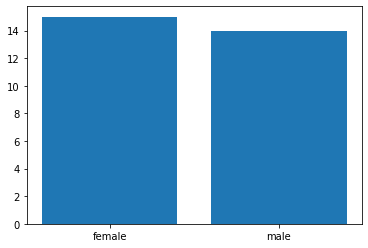

In [ ]:
counter_ytest = Counter(y_test)
plt.bar(counter_ytest.keys(), counter_ytest.values())

Nasze klasy są deliklatnie nierównoliczne, a więc użyjemy średniej ważonej. 



In [ ]:
SVM_test_preds = SVM.predict(X_test_scaled)
accuracy = accuracy_score(y_test, SVM_test_preds)
recall = recall_score(y_test, SVM_test_preds, average='weighted')
precision = precision_score(y_test, SVM_test_preds, average='weighted',zero_division=0)
f1 = f1_score(y_test, SVM_test_preds, average='weighted')
pd.DataFrame([accuracy,recall,precision,f1],['acc','recall','prec','f1'],columns=['values'])

,values
acc,0.482759
recall,0.482759
prec,0.233056
f1,0.314354


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, SVM_test_preds).ravel()
print('TN = ', tn, ' FP = ', fp, ' FN = ', fn, ' TP = ', tp)
data = confusion_matrix(y_test, SVM_test_preds)
pd.DataFrame(data,['1','0'],['1','0'])

TN =  0  FP =  15  FN =  0  TP =  14


,1,0
1,0,15
0,0,14


Widzimy, że nasze wyniki są bardzo słabe, a więc wymagane jest optymalizacja paraemtrów by osiągnąć lepszy rezultat. Optymalizujemy model na początku za pomocą metryki F1, która teoretycznie jest lepszą metryką, bo zawiera w sobie precyzję i czułość. 

In [ ]:
SVM = make_pipeline(StandardScaler(), SVC(C=1.0, random_state=42, probability=True))
SVM.fit(X_train, y_train)
SVM_test_preds = SVM.predict(X_test)
SVM_train_preds = SVM.predict(X_train)
scoring = {'f1_macro': make_scorer(f1_score, average='macro')}

Definujemy pozostałe potrzebne funkcje i zmienne.

In [ ]:
# obiekt
def objective(trial, model, get_space, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5), return_train_score=True)

    return np.mean(scores['test_f1_macro'])

In [ ]:
# model
model = LogisticRegression

def get_space(trial): 
    space = {"C": trial.suggest_uniform("C", 0, 1), 
           'max_iter': trial.suggest_int('max_iter', 100, 400),
           "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear"])}
    return space

trials = 3

Kod pozwalający obliczenie optymalnych parametrów

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda x: objective(x, model, get_space, X_train_scaled, y_train), n_trials=trials, show_progress_bar=True)
print('params: ', study.best_params)

[I 2023-01-02 17:59:08,909] A new study created in memory with name: no-name-b4512641-5d68-4ed9-9b25-5bd62c84f7bf
/usr/local/lib/python3.8/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/3 [00:00<?, ?it/s]

<ipython-input-27-0badda012dd3>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),
<ipython-input-27-0badda012dd3>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),


[I 2023-01-02 17:59:09,079] Trial 0 finished with value: 0.7830548751214386 and parameters: {'C': 0.2389661484094271, 'max_iter': 220, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7830548751214386.
[I 2023-01-02 17:59:09,204] Trial 1 finished with value: 0.7830548751214386 and parameters: {'C': 0.5220375731244068, 'max_iter': 324, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7830548751214386.


<ipython-input-27-0badda012dd3>:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),


[I 2023-01-02 17:59:09,331] Trial 2 finished with value: 0.7967545088210722 and parameters: {'C': 0.7995270909950722, 'max_iter': 164, 'solver': 'liblinear'}. Best is trial 2 with value: 0.7967545088210722.
params:  {'C': 0.7995270909950722, 'max_iter': 164, 'solver': 'liblinear'}


Tworzymy nowy model, który w teorii powinien działać lepiej.

In [ ]:
lr = model(**study.best_params)
lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)
print('f1_score: ', f1_score(y_test, preds,average='macro'))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print('TN = ', tn, ' FP = ', fp, ' FN = ', fn, ' TP = ', tp)
data = confusion_matrix(y_test, preds)
pd.DataFrame(data,['1','0'],['1','0'])

f1_score:  0.8605769230769231
TN =  11  FP =  4  FN =  0  TP =  14


,1,0
1,11,4
0,0,14


Taki sam zabieg zastosujemy dla metryki accuracu, aby sprawdzić co działa lepiej.

In [ ]:
SVM = make_pipeline(StandardScaler(), SVC(C=1.0, random_state=42, probability=True))
SVM.fit(X_train, y_train)
SVM_test_preds = SVM.predict(X_test)
SVM_train_preds = SVM.predict(X_train)

scoring = {'accuracy': make_scorer(accuracy_score)}

def objective(trial, model, get_space, X, y):
    model_space = get_space(trial)

    mdl = model(**model_space)
    scores = cross_validate(mdl, X, y, scoring=scoring, cv=StratifiedKFold(n_splits=5), return_train_score=True)

    return np.mean(scores['test_accuracy'])

In [ ]:
model = LogisticRegression
def get_space(trial): 
    space = {"C": trial.suggest_uniform("C", 0, 1), 
           'max_iter': trial.suggest_int('max_iter', 100, 400),
           "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear"])}
    return space

trials = 3

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda x: objective(x, model, get_space, X_train_scaled, y_train), n_trials=trials)
print('params: ', study.best_params)

[I 2023-01-02 17:59:19,297] A new study created in memory with name: no-name-d3ef6b03-6d27-41c7-9d8e-12d1af10bf7a
<ipython-input-31-8683ca355b25>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),
[I 2023-01-02 17:59:19,400] Trial 0 finished with value: 0.7882352941176471 and parameters: {'C': 0.30098041262981523, 'max_iter': 310, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.7882352941176471.
<ipython-input-31-8683ca355b25>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  space = {"C": trial.suggest_uniform("C", 0, 1),
[I 2023-01-02 17:59:19,520] Trial 1 finished with value: 0.7882352941176471 and pa

params:  {'C': 0.30098041262981523, 'max_iter': 310, 'solver': 'lbfgs'}


In [ ]:
lr = model(**study.best_params)
lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)
print('accuracy_score', accuracy_score(y_test, preds))
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print('TN = ', tn, ' FP = ', fp, ' FN = ', fn, ' TP = ', tp)
data = confusion_matrix(y_test, preds)
pd.DataFrame(data,['1','0'],['1','0'])

accuracy_score 0.896551724137931
TN =  12  FP =  3  FN =  0  TP =  14


,1,0
1,12,3
0,0,14
